
# Getting Started: Lagrangian Stochastic (LS) Footprint Model

This notebook shows how to use the **`ls_footprint_model.py`** module to compute a simple
2‑D flux footprint from eddy‑covariance tower data. It uses the attached example
configuration (`US-UTE.ini`) and data file referenced therein.



## 1) Setup

This section adjusts `sys.path` so you can import from your local source tree, then imports
the LS model. If you've installed the package, the first `import` will also work.


In [1]:

# --- Standard library
import os, sys, math, pathlib, warnings

# --- Third‑party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../../src")
from fluxfootprints.ls_footprint_model import LSFootprintConfig, BackwardLSModel

plt.rcParams["figure.dpi"] = 120
warnings.filterwarnings("ignore")
print("Imports ready.")


Imports ready.



## 2) Load site configuration and data

We read `US-UTE.ini` to discover the time column, wind variables, and file names. Then we load the
CSV it references and make a minimal set of variables needed by the LS model.


In [5]:

import configparser
from pathlib import Path

# Point to the example INI and CSV (adjust paths as needed)
ini_path = Path("US-UTE.ini")
if not ini_path.exists():
    ini_path = Path("./input_data/US-UTE.ini")  # fallback for this shared environment

cfg = configparser.ConfigParser(interpolation=None)
cfg.read(ini_path)

# Pull the essentials
date_col = cfg.get("DATA", "datestring_col")
date_fmt = cfg.get("METADATA", "date_parser")
skiprows = cfg.getint("METADATA", "skiprows", fallback=0)
missing_val = cfg.getfloat("METADATA", "missing_data_value", fallback=-9999.0)

# Columns for wind speed and direction
ws_col = cfg.get("DATA", "wind_spd_col", fallback="WS")
wd_col = cfg.get("DATA", "wind_dir_col", fallback="WD")

# Resolve the climate/data CSV next to the INI, or in the same folder
csv_rel = cfg.get("METADATA", "climate_file_path")
csv_path = ini_path.parent / csv_rel
if not csv_path.exists():
    csv_path = Path("/mnt/data") / csv_rel  # fallback

# Load data
parse = lambda s: pd.to_datetime(s, format=date_fmt, errors="coerce")
df = pd.read_csv(csv_path, skiprows=skiprows)
df[date_col] = df[date_col].apply(parse)
df = df.dropna(subset=[date_col]).set_index(date_col).sort_index()

# Basic cleaning for common missing value flags
df = df.replace({missing_val: np.nan, -9999: np.nan, -9999.0: np.nan})

print(f"Loaded {len(df):,} rows from:", csv_path)
df.head()


Loaded 4,463 rows from: input_data\US-UTE_HH_202406241430_202409251400.csv


,datetime_start,TIMESTAMP_END,CO2,CO2_SIGMA,H2O,H2O_SIGMA,FC,FC_SSITC_TEST,LE,LE_SSITC_TEST,...,TA_1_2_1,RH_1_2_1,T_DP_1_2_1,TA_1_3_1,RH_1_3_1,T_DP_1_3_1,TA_1_4_1,PBLH_F,TS_2_1_1,SWC_2_1_1
TIMESTAMP_START,,,,,,,,,,,,,,,,,,,,,
2024-06-24 14:30:00,2024-06-24 14:30:00,202406241500,427.0199,0.628133,17.26862,1.019290,0.069210,NaN,156.40850,NaN,...,29.95141,33.26877,12.052600,30.32464,33.45364,12.46181,30.06976,1665.4670,25.72815,22.44161
2024-06-24 15:00:00,2024-06-24 15:00:00,202406241530,425.9499,1.019297,15.18936,0.703052,0.285446,NaN,138.30920,NaN,...,30.02516,29.22197,10.155240,30.35956,29.77183,10.72635,30.13765,1765.9350,25.52736,22.41975
2024-06-24 15:30:00,2024-06-24 15:30:00,202406241600,426.4163,1.965228,14.87533,0.808026,1.081928,NaN,154.11530,NaN,...,30.24634,28.28498,9.838229,30.69433,28.63222,10.41335,30.40344,1495.7350,25.12511,22.32785
2024-06-24 16:00:00,2024-06-24 16:00:00,202406241630,426.0534,2.665907,15.61140,1.002919,0.519664,NaN,135.56180,NaN,...,30.75179,28.75255,10.538220,31.14621,29.16225,11.09066,30.90061,1491.0620,24.63557,22.18172
2024-06-24 16:30:00,2024-06-24 16:30:00,202406241700,427.8476,1.102921,15.21034,0.703084,1.147608,NaN,95.06287,NaN,...,29.16274,30.77158,10.165810,29.57434,30.96792,10.63069,29.30510,341.9711,24.14865,22.03216



## 3) Choose a time slice and prepare LS model inputs

The LS model needs:
- `zm` (receptor height, m)
- `ustar` (friction velocity, m s⁻¹)
- `L` (Monin–Obukhov length, m) — **not used** in this minimal implementation but kept for extension
- `h` (boundary‑layer height, m)
- `wind_dir_deg` (meteorological *from* direction, degrees)
- surface roughness `z0` and a numerical grid/domain

If your dataset has a `USTAR` column, we use that. Otherwise we estimate \(u_*\) from wind speed
by the neutral log‑law (requires assumptions for `zm` and `z0`).


In [6]:

KAPPA = 0.4

# Assumptions you can tune for your site
zm_default = 4.0   # receptor height [m]
z0_default = 0.1   # roughness length [m]
h_default  = 1000.0
L_default  = -50.0  # kept for API compatibility; not used in the core model

# Pick a representative timestamp with non‑missing wind + speed
needed = [wd_col]
if "USTAR" in df.columns:
    needed.append("USTAR")
else:
    needed.append(ws_col)

sub = df.dropna(subset=needed).copy()
if sub.empty:
    raise RuntimeError("No rows with required variables present. Check column names and missing values.")

row = sub.iloc[0]  # take the first valid row; feel free to select by date/time

# Derive ustar if needed
if "USTAR" in df.columns and pd.notna(row.get("USTAR")):
    ustar = float(row["USTAR"])
else:
    # Estimate u* with neutral log profile: u* = κ U / ln(zm / z0)
    U = float(row[ws_col])
    ustar = KAPPA * U / math.log(zm_default / z0_default)

wind_dir_deg = float(row[wd_col])
zm, z0, h, L = zm_default, z0_default, h_default, L_default

print(f"Selected time: {row.name}")
print(f"u* = {ustar:.3f} m s⁻1 | wind_dir = {wind_dir_deg:.1f}° | zm={zm} m, z0={z0} m, h={h} m")


Selected time: 2024-06-24 14:30:00
u* = 0.285 m s⁻1 | wind_dir = 83.8° | zm=4.0 m, z0=0.1 m, h=1000.0 m



## 4) Run the model


In [7]:

cfg = LSFootprintConfig(
    zm=zm,
    ustar=ustar,
    L=L,
    h=h,
    wind_dir_deg=wind_dir_deg,
    z0=z0,
    n_particles=20_000,   # increase for smoother fields
    dt=0.25,
    t_max=600.0,
    domain=(2000.0, 2000.0),
    dx=20.0,
    dy=20.0,
    seed=42,              # reproducible runs
)
model = BackwardLSModel(cfg)
model.run()

x, y, F = model.footprint()
xx, fx = model.crosswind_integrated()

F.min(), F.max(), F.sum()


(np.float64(0.0), np.float64(0.00039797840676442895), np.float64(0.0025))


## 5) Visualize the footprint


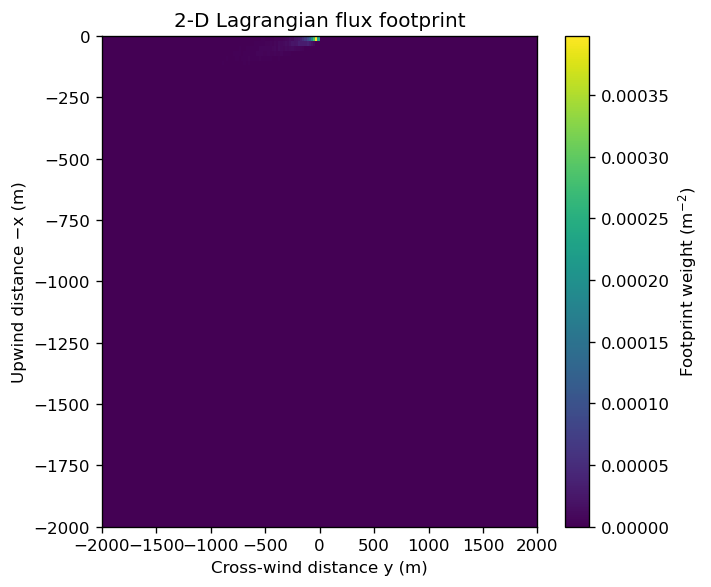

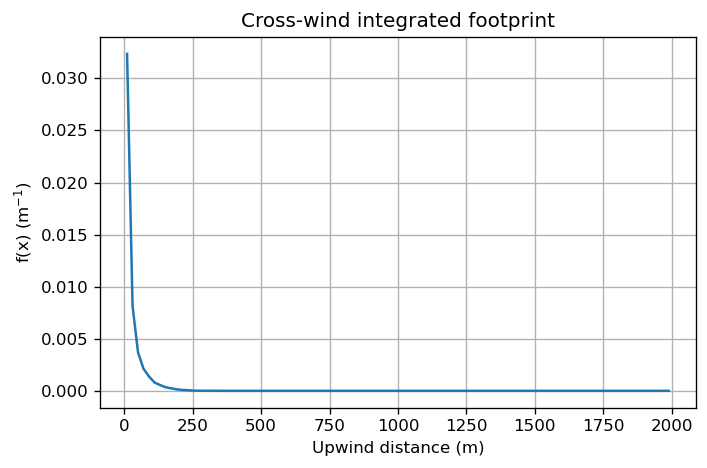

In [8]:

plt.figure(figsize=(6, 5))
plt.pcolormesh(y, x, F, shading="auto")
plt.colorbar(label="Footprint weight (m$^{-2}$)")
plt.xlabel("Cross‑wind distance y (m)")
plt.ylabel("Upwind distance −x (m)")
plt.title("2‑D Lagrangian flux footprint")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(-xx, fx)  # positive axis for downwind distance
plt.xlabel("Upwind distance (m)")
plt.ylabel("f(x) (m$^{-1}$)")
plt.title("Cross‑wind integrated footprint")
plt.grid(True)
plt.tight_layout()
plt.show()



## 6) Optional: 80% source area contour

Below we compute a density threshold such that the **integral** of the footprint inside the contour
is ~80% of the total. We then plot that as a single contour line.


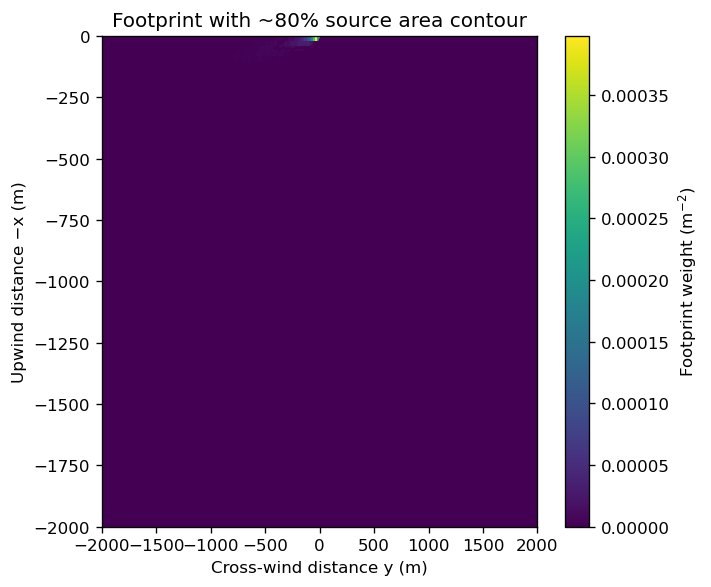

In [9]:

# Convert density (m^-2) to probability mass per cell
cell_mass = F * cfg.dx * cfg.dy
flat = cell_mass.ravel()
order = np.argsort(flat)[::-1]
csum = np.cumsum(flat[order])

# Find threshold where cumulative mass first exceeds 0.8
idx_thr = int(np.searchsorted(csum, 0.8))
thr_mass = flat[order][idx_thr]
thr_density = thr_mass / (cfg.dx * cfg.dy)

plt.figure(figsize=(6, 5))
plt.pcolormesh(y, x, F, shading="auto")
plt.colorbar(label="Footprint weight (m$^{-2}$)")
cc = plt.contour(y, x, F, levels=[thr_density])
plt.clabel(cc, fmt="80% area", inline=True, fontsize=8)
plt.xlabel("Cross‑wind distance y (m)")
plt.ylabel("Upwind distance −x (m)")
plt.title("Footprint with ~80% source area contour")
plt.tight_layout()
plt.show()



## 7) Save outputs (optional)


In [ ]:

out_dir = Path("outputs")
out_dir.mkdir(exist_ok=True)

# Save grids
np.save(out_dir / "footprint_density.npy", F)
np.savetxt(out_dir / "footprint_density.csv", F, delimiter=",")
np.savetxt(out_dir / "x_centers_m.csv", x, delimiter=",")
np.savetxt(out_dir / "y_centers_m.csv", y, delimiter=",")

# Save figures
plt.figure(figsize=(6, 5))
plt.pcolormesh(y, x, F, shading="auto")
plt.colorbar(label="Footprint weight (m$^{-2}$)")
plt.xlabel("Cross‑wind distance y (m)")
plt.ylabel("Upwind distance −x (m)")
plt.title("2‑D LS Footprint")
plt.tight_layout()
plt.savefig(out_dir / "footprint_2d.png", dpi=200)
plt.close()

plt.figure(figsize=(6, 4))
plt.plot(-xx, fx)
plt.xlabel("Upwind distance (m)")
plt.ylabel("f(x) (m$^{-1}$)")
plt.title("Cross‑wind integrated footprint")
plt.grid(True)
plt.tight_layout()
plt.savefig(out_dir / "footprint_fx.png", dpi=200)
plt.close()

print("Saved outputs to:", out_dir.resolve())



## 8) Tips & next steps

- Increase `n_particles` for smoother fields (e.g., 50,000–200,000).
- Adjust `domain`, `dx` and `dy` to control the spatial extent and resolution.
- If you have measured `USTAR`, use it directly; otherwise, provide a better local estimate for `z0` and set your actual `zm`.
- The current `L` parameter is kept for future extensions (e.g., stability‑dependent turbulence); it is not used in the core update step here.
- For climatological footprints, repeat runs across many time steps and average the resulting `F` fields (watch memory and runtime).
